# Hulu Time Series Analysis
### APRD 6343
### Author: Matt Hardwick
This notebook performs a time series analysis on Hulu searches using Google Trends data. The data has been pulled from Google's API and is differenced with one day of lag for stationarity. This book will decompose the data, then use Facebook Prophet to forecast trends. The model will then be supplemented with AdSpend data and be tested for Granger Causality.

## Exploratory Analysis
First, test for stationarity and plot basic timeseries trend.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from statsmodels.tsa import stattools
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

hulu = pd.read_csv('hulu_time_series.csv', parse_dates = ['period'])

In [2]:
hulu.head()

,Unnamed: 0,date,value,period,onediffvalue
0,0,Oct 07 2013,5514.573052,2013-10-07,NaN
1,1,Oct 08 2013,5254.403172,2013-10-08,-260.169880
2,2,Oct 09 2013,5501.185603,2013-10-09,246.782431
3,3,Oct 10 2013,5651.847077,2013-10-10,150.661474
4,4,Oct 11 2013,6173.720037,2013-10-11,521.872960


In [3]:
# test stationarity
adf_result = stattools.adfuller( hulu['onediffvalue'].iloc[1:] )
adf_result

(-10.468546697019457,
 1.302373985706241e-18,
 24,
 1795,
 {'1%': -3.4339982875683357,
  '10%': -2.567627919165742,
  '5%': -2.863151515989605},
 26542.02956918307)

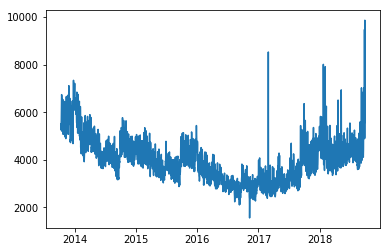

In [4]:
# plot basic trend
x = hulu['period']
y = hulu['value']

plt.plot(x,y)
plt.show()

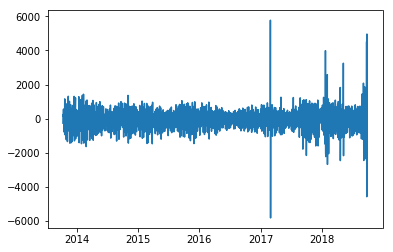

In [5]:
# plot difference data
y2 = hulu['onediffvalue']

plt.plot(x,y2)
plt.show()

The differenced data passes the stationarity test and can be used for further time series analysis. There are some clear outliers that will be addressed later. An initial observation shows a steady decline in searches for the first three years, but a steady increase towards the end of 2016.

## Decomposing Data
This code will clean and decompose the trend data in preparation for analyzing the seasonal, residual, and overall trends.

In [6]:
import matplotlib.dates as mdates
from statsmodels.tsa import seasonal

In [7]:
# remove time from date variable
hulu['period'] = hulu['period'].dt.date

# set period as index
hulu.set_index('period', inplace = True)

In [8]:
# pull years and months from data
years = mdates.YearLocator()
months = mdates.MonthLocator()
yearmonth = mdates.DateFormatter('%m.%y')

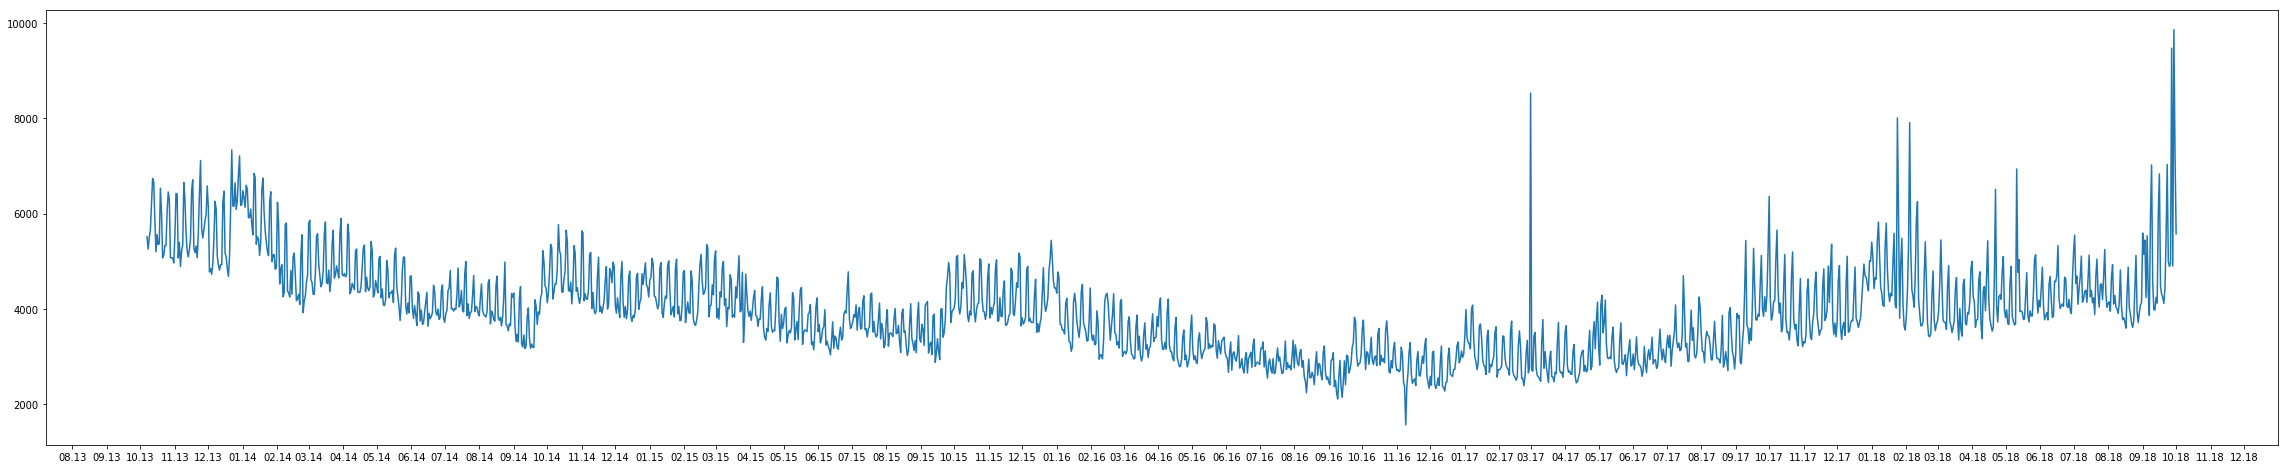

In [9]:
# plot overall trend
dimensions = (40, 8)
fig, ax = plt.subplots(figsize = dimensions)

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearmonth)

ax.plot(hulu.index, hulu['value'])

In [10]:
# establish seasonality trends
decompose_model = seasonal.seasonal_decompose(hulu['value'].tolist(), freq = 365, model = 'additive')

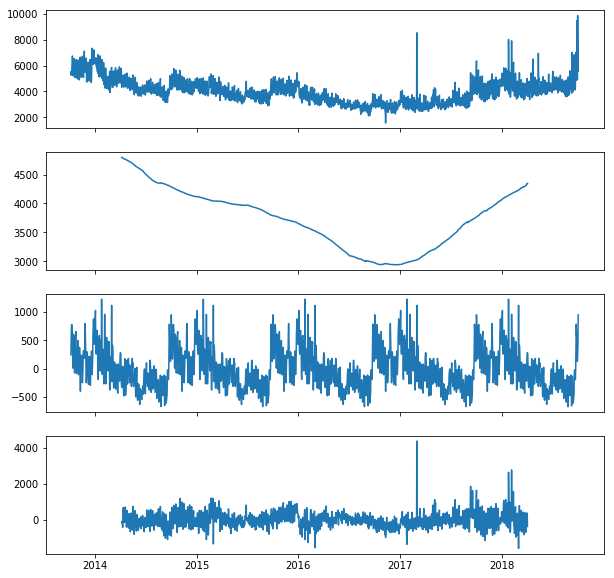

In [11]:
# plot decomposed data
dimensions = (10, 10)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = dimensions, sharex = 'all')

ax1.plot(hulu.index, hulu['value'])
ax2.plot(hulu.index, decompose_model.trend)
ax3.plot(hulu.index, decompose_model.seasonal)
ax4.plot(hulu.index, decompose_model.resid)

The four plots shown above are as follows:<br/>
1. Number of searches
2. Search trend
3. Seasonality
4. Residuals

There is a clear seasonal trend that is futher analyzed in the plot below.

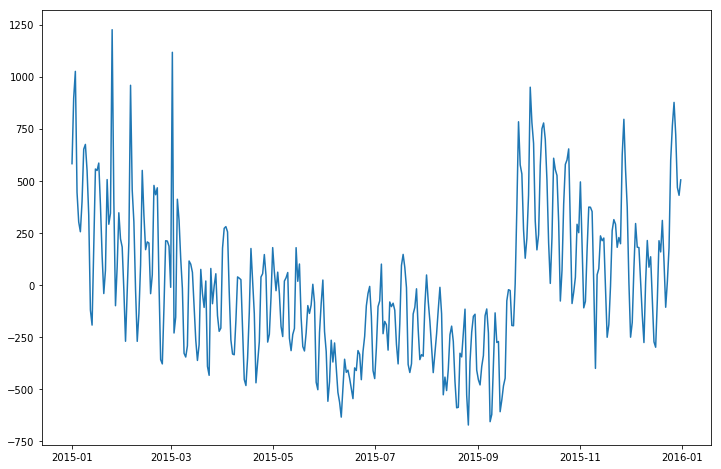

In [12]:
# view one year of seasonal time series
hulu['seasonal'] = decompose_model.seasonal

startdate = pd.to_datetime('2015-01-01').date()
enddate = pd.to_datetime('2015-12-31').date()

oneyear = hulu.loc[startdate:enddate] # .loc slices data from index

dimensions = (12, 8)
fig, ax = plt.subplots(figsize = dimensions)

ax.plot(oneyear.index, oneyear.seasonal)

There is a slow decrease in Hulu searches in the spring and summer, while searches rise in the fall and winter. This makes sense because as the days become colder and shorter people are more likely to stay inside and watch a streaming service like Hulu. This seasonal trend also suggests that holidays have some influence, which will be discussed later.

## Facebook Prophet
This code uses Facebook Prophet to forecast Hulu's search trend. It will account for holiday influence and help understand the outliers to minimize the error.

In [13]:
from fbprophet import Prophet
import holidays
from datetime import date

In [14]:
# view US holidays
goodholidays = []
for date, name in sorted(holidays.US(years=2014).items()):
    print(date, name)
    goodholidays.append(name)

2014-01-01 New Year's Day
2014-01-20 Martin Luther King, Jr. Day
2014-02-17 Washington's Birthday
2014-05-26 Memorial Day
2014-07-04 Independence Day
2014-09-01 Labor Day
2014-10-13 Columbus Day
2014-11-11 Veterans Day
2014-11-27 Thanksgiving
2014-12-25 Christmas Day


In [15]:
# remove holidays irrelevant to hulu
goodholidays.remove("Martin Luther King, Jr. Day")
goodholidays.remove("Washington's Birthday")
goodholidays.remove("Memorial Day")
goodholidays.remove("Independence Day")
goodholidays.remove("Labor Day")
goodholidays.remove("Columbus Day")
goodholidays.remove("Veterans Day")

The removed holidays are subjective but based on the seasonal trend. Hulu tends to promote more around fall and winter holidays than the ones removed.

In [16]:
# create sales df
sales = pd.DataFrame(columns=['holiday', 'ds', 'lower_window', 'upper_window'])

In [17]:
# add windows for holiday lag
for year in range(2014, 2021):
    for date, name in sorted(holidays.US(years=year).items()):
        lower_window = 0
        upper_window = 0
        if name in goodholidays:
            dayoftheweek = date.weekday() #extract holiday weekday
            #print(dayoftheweek)
            #print(date, name)
            if dayoftheweek == 0:
                lower_window = -2
            if dayoftheweek == 1:
                lower_window = -3
            if dayoftheweek == 3:
                upper_window = 3
            if dayoftheweek == 4:
                upper_window = 2
            sales.loc[len(sales)] = [name, date, lower_window, upper_window] #append new DF

Halloween and Valentine's Day are not included in the holidays package, but are holidays that should be included to fit the seasonal trend. Halloween and Valentine's movies are common, so Hulu likely promotes more around these times.

In [18]:
# add halloween and valentines day
more_holidays = pd.read_csv('more_holidays.csv', parse_dates = ['ds'])
more_holidays.head()

,holiday,ds,lower_window,upper_window
0,Halloween,2014-10-31,0,2
1,Halloween,2015-10-31,0,0
2,Halloween,2016-10-31,-2,0
3,Halloween,2017-10-31,-3,0
4,Halloween,2018-10-31,0,0


In [19]:
# merge holidays
sales = sales.append(more_holidays)

In [20]:
# sort by date
sales['ds'] = pd.to_datetime(sales['ds'])
sales = sales.sort_values(by=['ds'], ascending=True)
sales = sales.reset_index(drop=True)
sales.head()

,holiday,ds,lower_window,upper_window
0,New Year's Day,2014-01-01,0,0
1,Valentine's Day,2014-02-14,0,2
2,Halloween,2014-10-31,0,2
3,Thanksgiving,2014-11-27,0,3
4,Christmas Day,2014-12-25,0,3


In [21]:
# reload Hulu data for model
hulu = pd.read_csv("hulu_time_series.csv", parse_dates = ['period'])

In [22]:
# create df for prophet model
prophet_DF = pd.DataFrame()

prophet_DF['ds'] = hulu['period']
prophet_DF['y'] = hulu['value']

prophet_DF.head()

,ds,y
0,2013-10-07,5514.573052
1,2013-10-08,5254.403172
2,2013-10-09,5501.185603
3,2013-10-10,5651.847077
4,2013-10-11,6173.720037


In [23]:
# initialize model
m = Prophet(holidays=sales)

# add holidays to prophet model
m.add_country_holidays(country_name='US')

# fit model
m.fit(prophet_DF)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prophet comes with a parameter called changepoints that input specific dates as times to change the trend. While there is a notable changepoint at the end of 2016, Prophet's automatic changepoint detector creates a lower error than manually inputed changepoints.

In [24]:
# forecast a year of searches
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

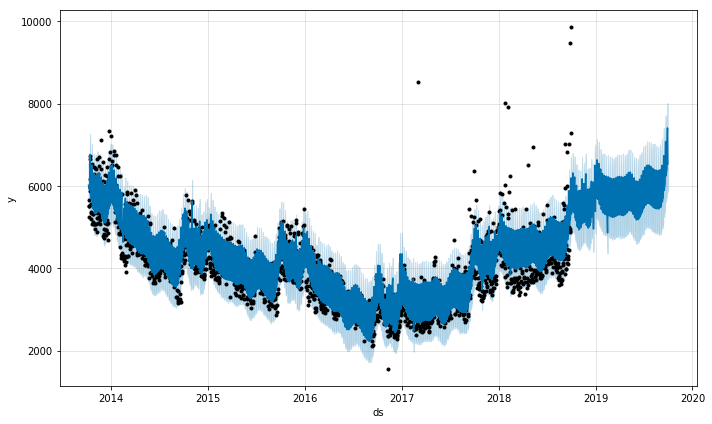

In [25]:
# plot forecast
fig1 = m.plot(forecast)

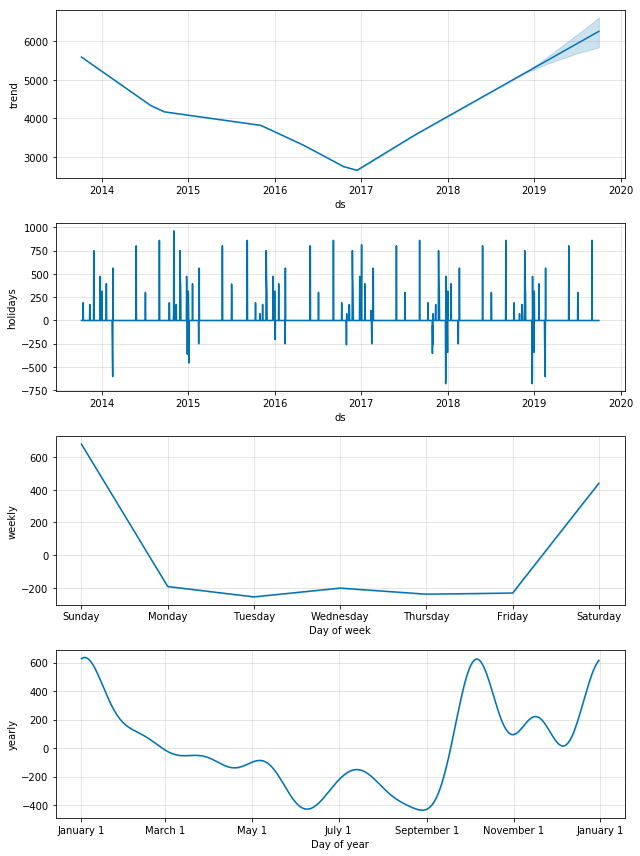

In [26]:
# plot components
fig = m.plot_components(forecast)

The forecast predicts a upward search trend into 2020. The component plots are intuitive as the majority of holidays generate more searches, people are less likely to watch Hulu on weekdays, and the yearly trend matches the seasonal trend.

In [27]:
# conduct error analysis
error_analysis = m.predict(prophet_DF)

error_analysis['value'] = prophet_DF['y']
error_analysis['residuals'] = error_analysis['value'] - error_analysis['yhat']
error_analysis['absoluteresiduals'] = abs(error_analysis['residuals'])

In [28]:
# calculate mean error
total_error = error_analysis['absoluteresiduals'].sum()

total_error / len(error_analysis)

251.85556698027472

In [29]:
# check outliers
print(error_analysis[['ds', 'absoluteresiduals']].nlargest(10, 'absoluteresiduals'))

             ds  absoluteresiduals
1241 2017-03-01        5793.735134
1816 2018-09-27        4312.616758
1818 2018-09-29        3940.986390
1570 2018-01-24        3809.934291
1581 2018-02-04        2917.876339
1677 2018-05-11        2767.067899
1571 2018-01-25        1875.217723
1798 2018-09-09        1751.031954
1658 2018-04-22        1530.840554
1305 2017-05-04        1420.850613


Researching Hulu on Google News for these dates provides some explanation for the outliers:

2017-03-01 | National Treasure<br>
2018-09-27 | Quality Study<br>
2018-09-29 | Quality Study<br>
2018-01-24 | Login Issues<br>
2018-02-04 | Castle Rock Super Bowl Commercial & Stream Down<br>
2018-05-11 | Brooklyn 99 Pass<br>
2018-01-25 | Login Issues<br>
2018-09-09 | Stream NFL<br>
2018-04-22 | Handmaid's Tale Review<br>
2018-05-04 | May the Fourth Promo<br>

On March 1, 2017 Hulu released *National Treasure*, a miniseries about a fictional celebrity rape scandal. The show's controversial content and timeliness around the Bill Cosby case generated a lot of attention that likely contributed to the outlier. Similarly, the *Castle Rock* commercial, NFL streaming service, *Handmaid's Tale* Review, and May the Fourth Promo are all outliers regarding Hulu's content. They each have a timely advantage, such as advertising their NFL streaming as the season starts and promoting the *Star Wars* series on a punny day. Hulu should continue to time their promotions and services with notable events to improve their search trend.

Unfortunately, not all outlier events are positive for Hulu's image. Some trend outliers are caused by subscriber inconveniences, such as the login issues, crashing streams, and passing on renewing *Brooklyn Nine-Nine*. Hulu users experienced login issues for two days, and their streaming service went down during the final minutes of the 2018 Super Bowl. Hulu also opted out from renewing the popular comedy series *Brooklyn Nine-Nine*, which was picked up by NBC the next day. Hulu needs to improve its service quality and retain popular shows in order to avoid losing customers to Netflix, Amazon, and other competitors.

The Quality Study is the only outlier that can have a positive or negative effect on Hulu's brand. The study compares Hulu's content and price with its competitors and analyzes which streaming service is superior to others. Hulu ranks the best for quality TV shows, but lacks in quality movies and overall media quantity. This review can help Hulu attract customers more interested in shows, but hurts their market of movie junkies. Hulu can improve its service and attract new customers by improving their movies.

## AdSpend Clean Up
This code will add Google AdSpend data to the model to prepare for correlation and Granger Causality tests.

In [30]:
import numpy as np

In [31]:
adspend = pd.read_csv('hulu.adspend.csv')
adspend.head()

,TIME PERIOD,PRODUCT,TOTAL DOLS (000),NETWORK TV DOLS (000),CABLE TV DOLS (000),SYNDICATION DOLS (000),SPOT TV DOLS (000),MAGAZINES DOLS (000),SUNDAY MAGS DOLS (000),NATL NEWSP DOLS (000),NEWSPAPER DOLS (000),NETWORK RADIO DOLS (000),NAT SPOT RADIO DOLS (000),OUTDOOR DOLS (000)
0,"WEEK OF OCT 07, 2013 (B)",Hulu : Online,47.8,0.0,0.0,0.0,47.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"WEEK OF OCT 07, 2013 (B)",Hulu Online & Hulu Plus Online : Combo,4.2,0.0,0.0,0.0,4.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"WEEK OF OCT 07, 2013 (B)",Hulu Plus : Online,763.2,0.0,363.8,379.9,19.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"WEEK OF OCT 14, 2013 (B)",Hulu : Online,40.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"WEEK OF OCT 14, 2013 (B)",Hulu Online & Hulu Plus Online : Combo,3.6,0.0,0.0,0.0,3.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# clean up time period
adspend['TIME PERIOD'] = adspend['TIME PERIOD'].str.replace('WEEK OF ', '', regex = True)
adspend['TIME PERIOD'] = adspend['TIME PERIOD'].str.replace(' \(B\)', '', regex = True) #removes (B)

In [33]:
# clean up column names
adspend.columns = adspend.columns.str.replace(' DOLS \(000\)', '', regex = True)

In [34]:
# coerce to date
adspend['FIXED TIME'] = pd.to_datetime(adspend['TIME PERIOD'])

In [35]:
# aggregate sum on time
adspendnoproducts = adspend.pivot_table(index = 'FIXED TIME', aggfunc = np.sum)

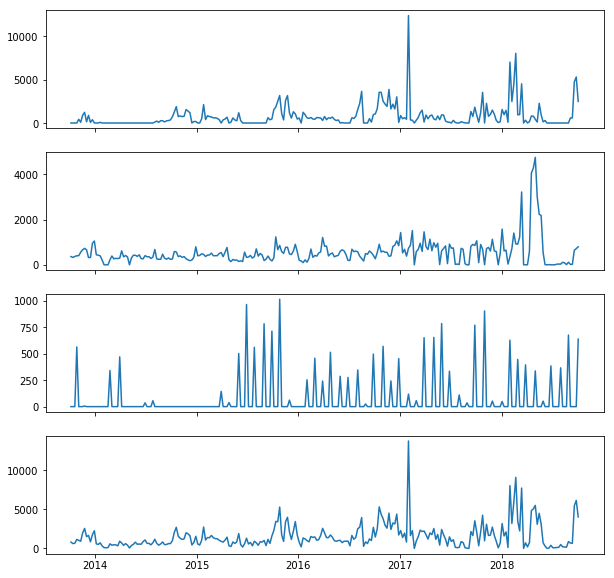

In [36]:
# plot some adspend trends
dimensions = (10, 10)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = dimensions, sharex = 'all')

ax1.plot(adspendnoproducts.index, adspendnoproducts['NETWORK TV'])
ax2.plot(adspendnoproducts.index, adspendnoproducts['CABLE TV'])
ax3.plot(adspendnoproducts.index, adspendnoproducts['OUTDOOR'])
ax4.plot(adspendnoproducts.index, adspendnoproducts['TOTAL'])

Ad spending spikes at the beginning of 2017, around the time the overall search trend began to increase. A Granger Causality test will check for correlation later.

In [37]:
# reload Hulu trend data
hulu = pd.read_csv('hulu_time_series.csv', parse_dates = ['period'])
hulu.set_index('period', inplace=True)

In [38]:
# sample data by weekly averages
hulu_weekly = hulu.resample('W-MON', closed = 'left', label = 'left').mean()
hulu_weekly.head()

,Unnamed: 0,value,onediffvalue
period,,,
2013-10-07,3,5928.132884,191.427240
2013-10-14,10,5702.045919,-92.676918
2013-10-21,17,5661.400116,40.318614
2013-10-28,24,5507.568569,16.023152
2013-11-04,31,5551.972915,-15.555643


In [39]:
# merge datasets
adspend_trends = adspendnoproducts.join(hulu_weekly)
adspend_trends.head()

,CABLE TV,MAGAZINES,NAT SPOT RADIO,NATL NEWSP,NETWORK RADIO,NETWORK TV,NEWSPAPER,OUTDOOR,SPOT TV,SUNDAY MAGS,SYNDICATION,TOTAL,Unnamed: 0,value,onediffvalue
FIXED TIME,,,,,,,,,,,,,,,
2013-10-07,363.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.5,0.0,379.9,815.2,3,5928.132884,191.427240
2013-10-14,325.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.2,0.0,250.5,619.8,10,5702.045919,-92.676918
2013-10-21,369.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.5,0.0,253.9,668.3,17,5661.400116,40.318614
2013-10-28,400.6,0.0,0.0,0.0,1.7,0.0,0.0,563.5,45.9,0.0,143.3,1155.0,24,5507.568569,16.023152
2013-11-04,402.3,0.0,0.0,0.0,4.0,430.8,0.0,0.0,48.3,0.0,152.6,1038.0,31,5551.972915,-15.555643


## Correlations Test
This code will make the AdSpend data stationary and perform correlation tests.

In [40]:
# make data stationary with weekly difference
adspend_trends['TOTALdiff'] = adspend_trends['TOTAL'].diff(1)
adspend_trends['valuediff'] = adspend_trends['value'].diff(1)
adspend_trends.head()

,CABLE TV,MAGAZINES,NAT SPOT RADIO,NATL NEWSP,NETWORK RADIO,NETWORK TV,NEWSPAPER,OUTDOOR,SPOT TV,SUNDAY MAGS,SYNDICATION,TOTAL,Unnamed: 0,value,onediffvalue,TOTALdiff,valuediff
FIXED TIME,,,,,,,,,,,,,,,,,
2013-10-07,363.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.5,0.0,379.9,815.2,3,5928.132884,191.427240,NaN,NaN
2013-10-14,325.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.2,0.0,250.5,619.8,10,5702.045919,-92.676918,-195.4,-226.086966
2013-10-21,369.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.5,0.0,253.9,668.3,17,5661.400116,40.318614,48.5,-40.645802
2013-10-28,400.6,0.0,0.0,0.0,1.7,0.0,0.0,563.5,45.9,0.0,143.3,1155.0,24,5507.568569,16.023152,486.7,-153.831547
2013-11-04,402.3,0.0,0.0,0.0,4.0,430.8,0.0,0.0,48.3,0.0,152.6,1038.0,31,5551.972915,-15.555643,-117.0,44.404346


In [41]:
# test stationary data correlation
adspend_trends['TOTALdiff'].corr(adspend_trends['valuediff'])

-0.0005978384771783118

There is basically no correlation between total adspend and search values for the stationary data. In order to test individual adspend correlations, each medium must be made stationary.

In [42]:
# drop irrelevant columns
adspend_trends = adspend_trends.drop(columns = ['onediffvalue', 'Unnamed: 0', 'TOTALdiff', 'valuediff'])

In [43]:
# test stationarity significance < 0.05
for column in list(adspend_trends):
    adf_result = stattools.adfuller(adspend_trends[column])
    print(adf_result[1] < 0.05, adf_result[1])

True 0.007713880957820488
False 0.38905454403377715
False 0.10968844638242159
False 0.21373439260331528
True 0.01890971162318696
True 3.477134298034589e-06
True 6.172139576042826e-26
True 0.0035242155323943554
True 7.869104059518442e-22
True 0.0017426017050936465
True 0.001545664947020707
True 1.985241318472535e-09
False 0.4009056019602835


Four variables are insignificant. Need to difference the data for further analysis.

In [44]:
adspend_trends_diff = pd.DataFrame()

In [45]:
for column in list(adspend_trends):
    columnname = '%s_diff' % (column)
    adspend_trends_diff[columnname] = adspend_trends[column].diff(1)

In [46]:
adspend_trends_diff.head()

,CABLE TV_diff,MAGAZINES_diff,NAT SPOT RADIO_diff,NATL NEWSP_diff,NETWORK RADIO_diff,NETWORK TV_diff,NEWSPAPER_diff,OUTDOOR_diff,SPOT TV_diff,SUNDAY MAGS_diff,SYNDICATION_diff,TOTAL_diff,value_diff
FIXED TIME,,,,,,,,,,,,,
2013-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-14,-38.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-27.3,0.0,-129.4,-195.4,-226.086966
2013-10-21,44.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,3.4,48.5,-40.645802
2013-10-28,30.8,0.0,0.0,0.0,1.7,0.0,0.0,563.5,1.4,0.0,-110.6,486.7,-153.831547
2013-11-04,1.7,0.0,0.0,0.0,2.3,430.8,0.0,-563.5,2.4,0.0,9.3,-117.0,44.404346


In [47]:
# retest stationarity significance < 0.05
for column in list(adspend_trends_diff):
    adf_result = stattools.adfuller(adspend_trends_diff[column].iloc[1:])
    print(adf_result[1] < 0.05, adf_result[1])

True 2.071641414057955e-10
True 1.5872089579138634e-11
True 8.910735698213089e-12
True 1.3640885630889368e-16
True 3.8031491692881125e-10
True 3.7799271689052613e-06
True 1.023435128110326e-18
True 4.99813802241073e-10
True 1.2063681099345782e-15
True 1.2984591085383814e-13
True 7.7979400101523955e-25
True 4.1030522073494833e-13
True 1.453881690828322e-08


All variables are now stationary and can be tested for individual correlation.

In [48]:
# compare correlations for each column
correlationlist = []
for column in list(adspend_trends_diff):
    if 'value' not in column:
        corr = adspend_trends_diff[column].corr(adspend_trends_diff['value_diff'])
        print(column, corr)
        correlationlist.append(corr)

CABLE TV_diff 0.08015956381665965
MAGAZINES_diff 0.1239748892006762
NAT SPOT RADIO_diff 0.0032566375063522767
NATL NEWSP_diff 0.10729784405842051
NETWORK RADIO_diff -0.05058959969534989
NETWORK TV_diff -0.03936308468883195
NEWSPAPER_diff -0.024624431709573666
OUTDOOR_diff -0.02755561653894462
SPOT TV_diff 0.043578784184075334
SUNDAY MAGS_diff -0.13815441701880032
SYNDICATION_diff 0.0309174166648682
TOTAL_diff -0.0005978384771783118


In [49]:
np.mean(correlationlist)

0.009025012275197785

The average stationary adspend and value correlation is higher than the total spend and value correlation. However, it is still less than 1%. Magazines, national newspapers, and sunday magazines have the highest correlations with search value. While this may suggest that increasing spend in magazines and national papers will have a positive effect on search trends, the sample size of the two variables may be too low.

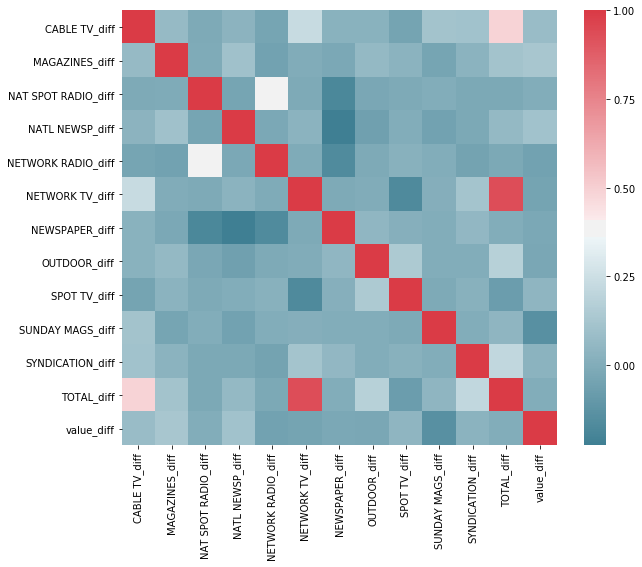

In [50]:
# plot correlation matrix
f, ax = plt.subplots(figsize=(10, 8))
corr = adspend_trends_diff.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
           square=True, ax=ax)

Cable TV and network TV have the highest correlations with total spend, meaning that the majority of Hulu adspend is on those two outlets. It's hard to believe that the print media listed above have significant impacts on search trends since Hulu hardly spends on print advertising.

## Granger Causality
This code will test for significant search trend predictors with up to eight weeks of lag.

In [51]:
# check lag up to 2 months
numofweeks = 8
significantlags = []

In [52]:
# granger causality test
for column in list(adspend_trends_diff):
    if 'value' not in column:
        testframe = adspend_trends_diff[['value_diff', column]]
        testframe = testframe.iloc[1:]
        results = stattools.grangercausalitytests(testframe, numofweeks, verbose=False)
        for week in range(1, numofweeks+1):
            if results[week][0]['params_ftest'][1] < 0.05: #significance test
                print('%s is significant at %s weeks' % (column, week))
                significantlags.append(week)

NETWORK TV_diff is significant at 3 weeks
NETWORK TV_diff is significant at 4 weeks
NETWORK TV_diff is significant at 5 weeks
NETWORK TV_diff is significant at 6 weeks
OUTDOOR_diff is significant at 4 weeks
OUTDOOR_diff is significant at 5 weeks
OUTDOOR_diff is significant at 7 weeks
OUTDOOR_diff is significant at 8 weeks
TOTAL_diff is significant at 3 weeks
TOTAL_diff is significant at 4 weeks
TOTAL_diff is significant at 5 weeks
TOTAL_diff is significant at 6 weeks
TOTAL_diff is significant at 7 weeks
TOTAL_diff is significant at 8 weeks


The Granger test suggests there is lag up to six weeks for network TV and eight weeks for outdoor ads. By creating a new dataset that accounts for the lag, one can find significant predictors using a LASSO regression. 

In [53]:
# duplicate dataframe
modelingdataset = adspend_trends_diff

In [54]:
# add eight weeks lag
date = pd.to_datetime('2018-10-08')
modelingdataset.loc[date] = np.nan

date = pd.to_datetime('2018-10-15')
modelingdataset.loc[date] = np.nan

date = pd.to_datetime('2018-10-22')
modelingdataset.loc[date] = np.nan

date = pd.to_datetime('2018-10-29')
modelingdataset.loc[date] = np.nan

date = pd.to_datetime('2018-11-05')
modelingdataset.loc[date] = np.nan

date = pd.to_datetime('2018-11-12')
modelingdataset.loc[date] = np.nan

date = pd.to_datetime('2018-11-19')
modelingdataset.loc[date] = np.nan

date = pd.to_datetime('2018-11-26')
modelingdataset.loc[date] = np.nan

In [55]:
# add lag columns
for column in list(modelingdataset):
    if 'value' not in column:
        for lag in range(1,9):
            columnname = '%s_lag%s' % (column, lag)
            modelingdataset[columnname] = modelingdataset[column].shift(lag)

In [56]:
modelingdataset.sort_index(axis=1, inplace=True)

In [57]:
# check columns
list(modelingdataset)

['CABLE TV_diff',
 'CABLE TV_diff_lag1',
 'CABLE TV_diff_lag2',
 'CABLE TV_diff_lag3',
 'CABLE TV_diff_lag4',
 'CABLE TV_diff_lag5',
 'CABLE TV_diff_lag6',
 'CABLE TV_diff_lag7',
 'CABLE TV_diff_lag8',
 'MAGAZINES_diff',
 'MAGAZINES_diff_lag1',
 'MAGAZINES_diff_lag2',
 'MAGAZINES_diff_lag3',
 'MAGAZINES_diff_lag4',
 'MAGAZINES_diff_lag5',
 'MAGAZINES_diff_lag6',
 'MAGAZINES_diff_lag7',
 'MAGAZINES_diff_lag8',
 'NAT SPOT RADIO_diff',
 'NAT SPOT RADIO_diff_lag1',
 'NAT SPOT RADIO_diff_lag2',
 'NAT SPOT RADIO_diff_lag3',
 'NAT SPOT RADIO_diff_lag4',
 'NAT SPOT RADIO_diff_lag5',
 'NAT SPOT RADIO_diff_lag6',
 'NAT SPOT RADIO_diff_lag7',
 'NAT SPOT RADIO_diff_lag8',
 'NATL NEWSP_diff',
 'NATL NEWSP_diff_lag1',
 'NATL NEWSP_diff_lag2',
 'NATL NEWSP_diff_lag3',
 'NATL NEWSP_diff_lag4',
 'NATL NEWSP_diff_lag5',
 'NATL NEWSP_diff_lag6',
 'NATL NEWSP_diff_lag7',
 'NATL NEWSP_diff_lag8',
 'NETWORK RADIO_diff',
 'NETWORK RADIO_diff_lag1',
 'NETWORK RADIO_diff_lag2',
 'NETWORK RADIO_diff_lag3',
 'NE

## LassoLars
This code will create a LassoLars model to test for lagged adspend predictors.

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoLarsCV
from sklearn.metrics import mean_squared_error

In [59]:
# remove NA rows
modelingdataset = modelingdataset.iloc[9:]
modelingdataset = modelingdataset.iloc[:-9]

In [60]:
predictors_list = []
for var in list(modelingdataset):
    if 'value' not in var:
        predictors_list.append(var)

In [61]:
# save X df
predictors = modelingdataset[predictors_list]

# save Y df
target = modelingdataset['value_diff']

In [62]:
# partition data
pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, target, test_size=0.3, random_state=123)

In [63]:
# fit model
model = LassoLarsCV(cv=10, precompute=False)
model = model.fit(pred_train.values, tar_train.values)

In [64]:
# create predictors
predictors_model = pd.DataFrame(predictors_list)
predictors_model.columns = ['label']
predictors_model['coeff'] = model.coef_

In [65]:
# positive predictors of unique variance
for index, row in predictors_model.iterrows():
    if row['coeff'] > 0:
        print(row.values)

['NETWORK RADIO_diff_lag3' 1.7225473048732227]
['OUTDOOR_diff_lag8' 0.023292593338382635]
['TOTAL_diff_lag4' 0.004484365891069923]


In [66]:
# train model strength
train_error = mean_squared_error(tar_train, model.predict(pred_train))
print('training data MSE')
print(train_error)

train_r2 = model.score(pred_train, tar_train)
print('training data r-squared')
print(train_r2)

training data MSE
71859.2670305035
training data r-squared
0.1270752516644852


In [67]:
# test model strength
test_error = mean_squared_error(tar_test, model.predict(pred_test))
print('test data MSE')
print(test_error)

test_r2 = model.score(pred_test, tar_test)
print('test data r-squared')
print(test_r2)

test data MSE
99215.76339759248
test data r-squared
-0.009314920133376647


Although the Lasso model suggests there are positive effects from lagged media, the test r-squared basically renders the entire model insignificant. It seems that media adspend is not a good predictor of Hulu trends. Although it lacks individual variable predictive power, the Facebook Prophet model is the best model for forecasting trends.